In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
habits_df = pd.read_csv("/content/drive/MyDrive/student_habits_performance.csv")
habits_df.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [4]:
# Removing unnecessary column
habits_df.drop('student_id', axis=1, inplace=True)

## Visualising data

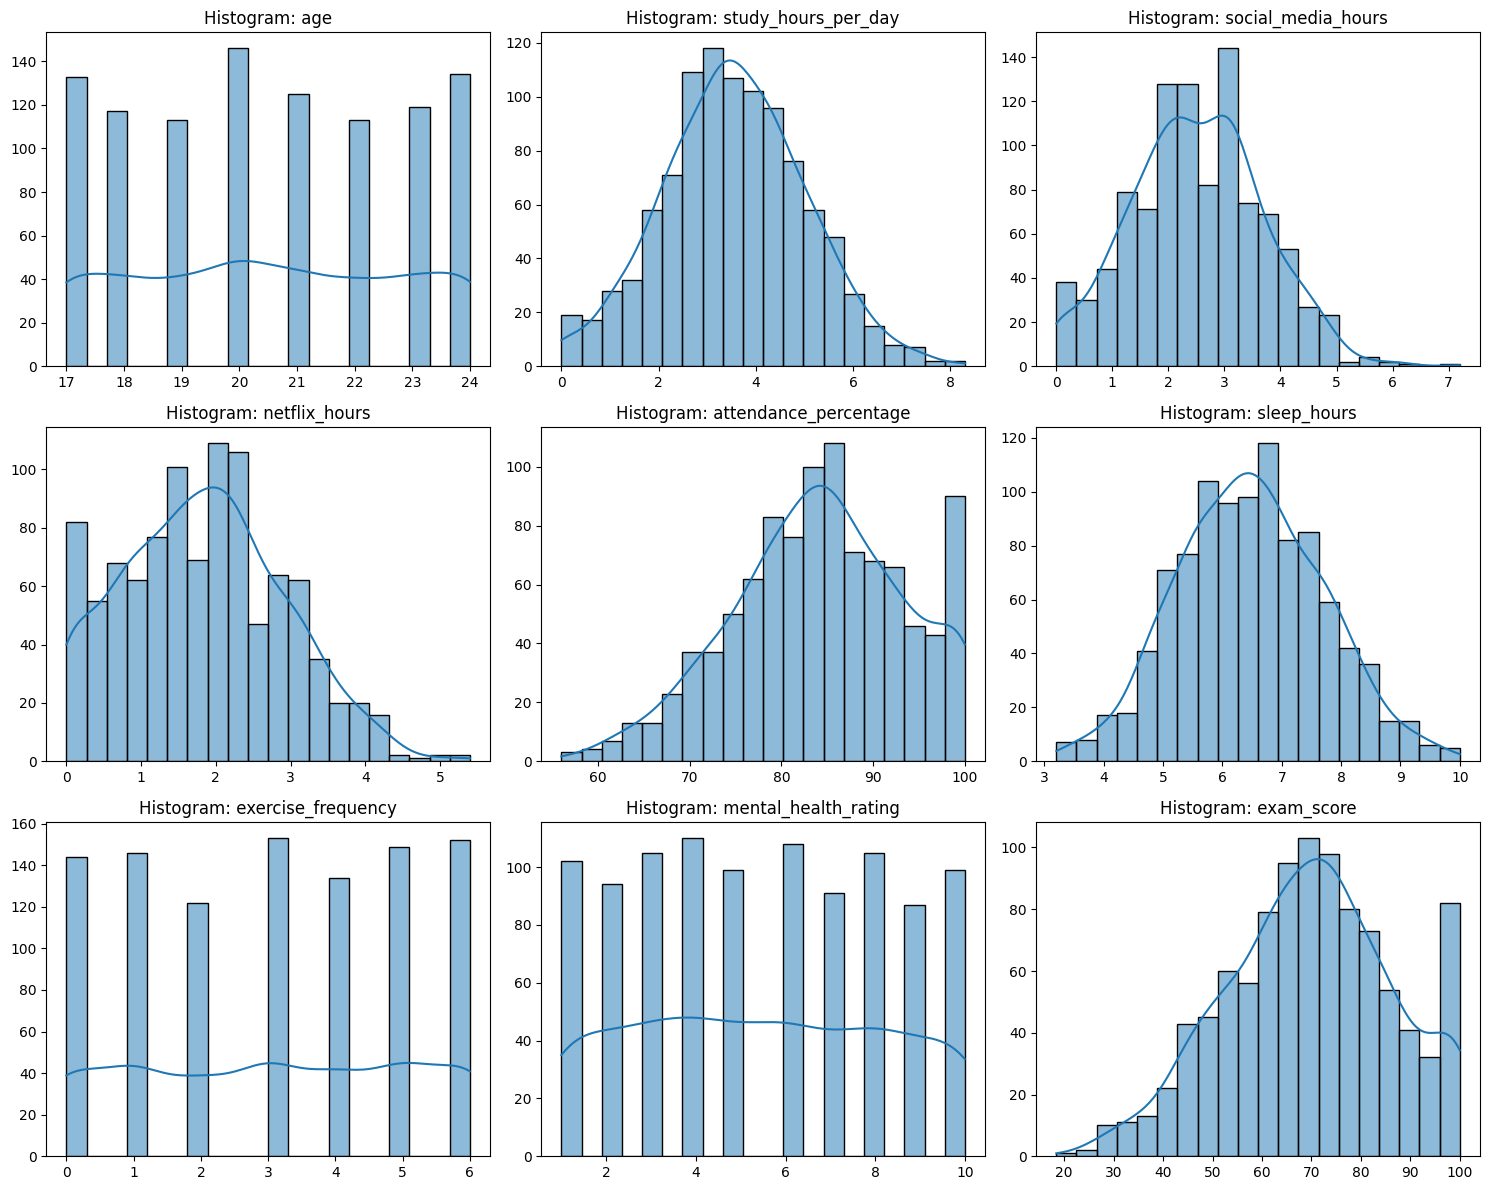

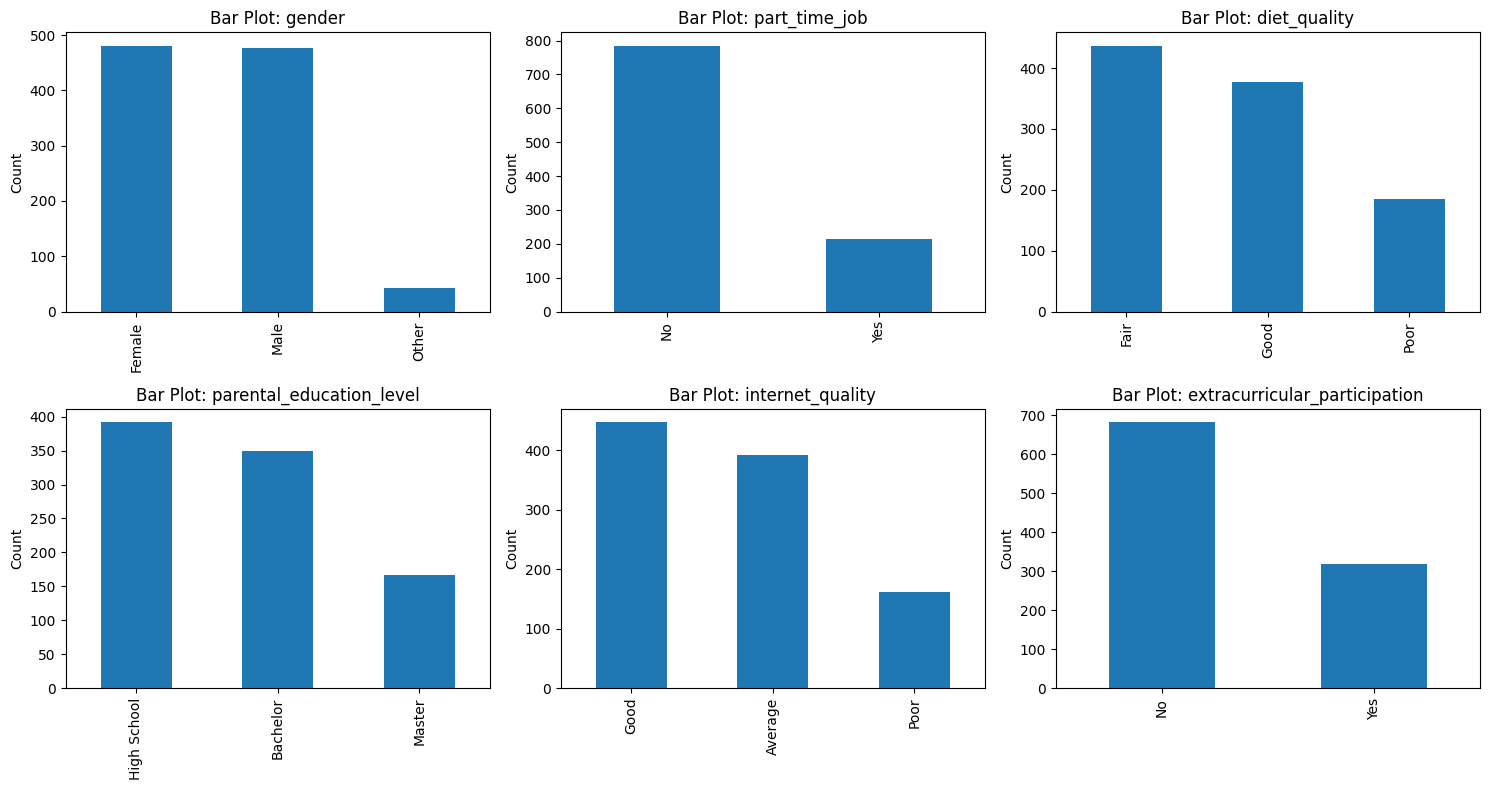

In [5]:
# Separate numeric and categorical columns
numeric_cols = habits_df.select_dtypes(include='number').columns
categorical_cols = habits_df.select_dtypes(exclude='number').columns


# 1. Histograms for numeric columns
n_num = len(numeric_cols)
n_cols = 3
n_rows = (n_num + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(habits_df[col].dropna(), kde=True, ax=axes[i], bins=20)
    axes[i].set_title(f"Histogram: {col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


# 2. Bar plots for categorical columns
n_cat = len(categorical_cols)
n_cols = 3
n_rows = (n_cat + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    habits_df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"Bar Plot: {col}")
    axes[i].set_ylabel("Count")
    axes[i].set_xlabel("")

# Removes empty subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### Inferential statistics

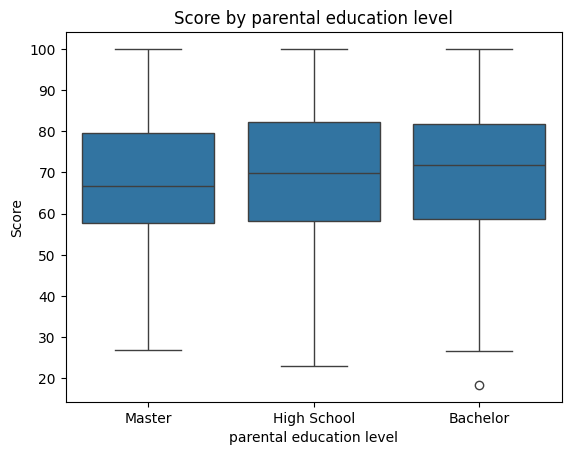

In [6]:
# Boxplot displaying scores by parental education level
sns.boxplot(x="parental_education_level", y="exam_score", data=habits_df)
plt.title("Score by parental education level")
plt.xlabel("parental education level")
plt.ylabel("Score")
plt.show()

Based on this boxplot, parental education has no significant impact in the sutdet's score

### Correlation Plot

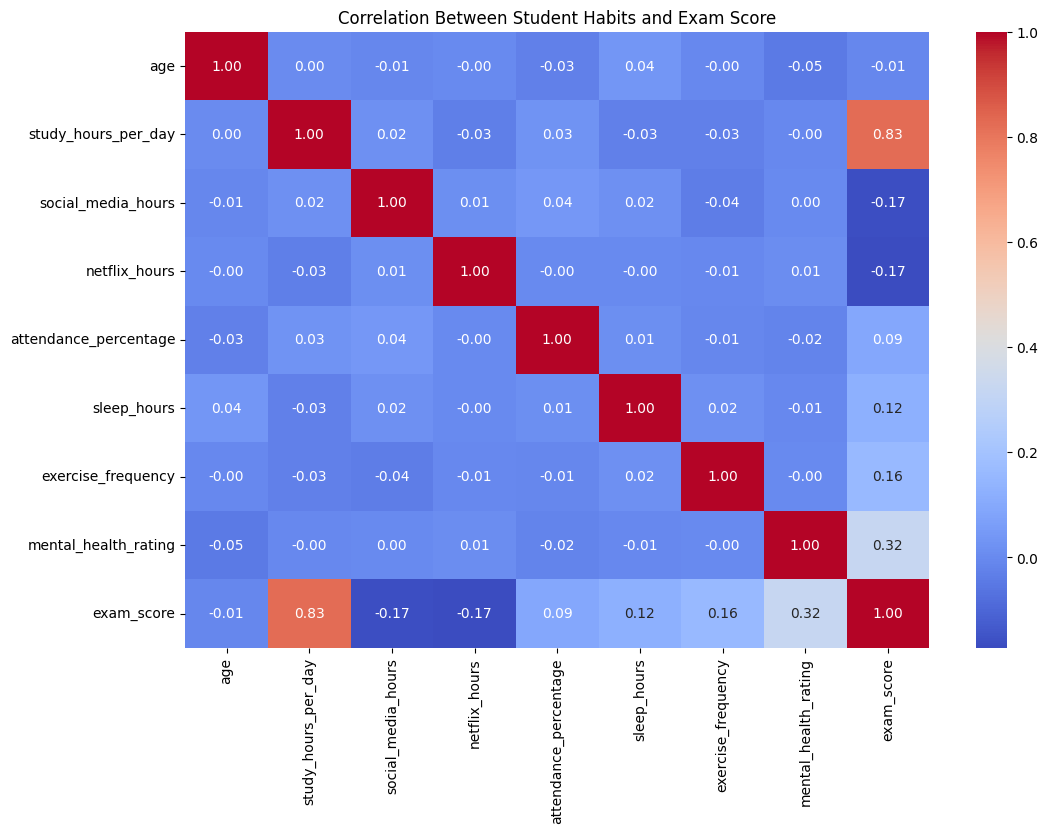

In [7]:
plt.figure(figsize=(12, 8))
sns.heatmap(habits_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Student Habits and Exam Score')
plt.show()

As we can see inmediately from the correlation plot, the feature most correlated to the exam_score target is study_hours_per_day, followed by mental_health_rating

## Data preprocessing


In [8]:
habits_df.isna().sum()

,0
age,0
gender,0
study_hours_per_day,0
social_media_hours,0
netflix_hours,0
part_time_job,0
attendance_percentage,0
sleep_hours,0
diet_quality,0
exercise_frequency,0


In [9]:
# We should do something about missing values in the parental education level feature
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
habits_df['parental_education_level'] = imputer.fit_transform(habits_df[['parental_education_level']]).ravel()

habits_df.isna().sum()

,0
age,0
gender,0
study_hours_per_day,0
social_media_hours,0
netflix_hours,0
part_time_job,0
attendance_percentage,0
sleep_hours,0
diet_quality,0
exercise_frequency,0


In [10]:
# For feature engineering we can create a feature called engagement_score, combining study_hours_per_week and atttendance_percentage

# Normalize attendance
habits_df['attendance_norm'] = habits_df['attendance_percentage'] / 100.0

# Normalize study_hours_per_week using min-max scaling
habits_df['study_hours_norm'] = (habits_df['study_hours_per_day'] - habits_df['study_hours_per_day'].min()) / \
                         (habits_df['study_hours_per_day'].max() - habits_df['study_hours_per_day'].min())

# Create engagement score as the average of normalized values
habits_df['engagement_score'] = (habits_df['attendance_norm'] + habits_df['study_hours_norm']) / 2

habits_df.drop(['attendance_norm', 'study_hours_norm'], axis=1, inplace=True)

habits_df[['attendance_percentage', 'study_hours_per_day', 'engagement_score']].head()

,attendance_percentage,study_hours_per_day,engagement_score
0,85.0,0.0,0.425000
1,97.3,6.9,0.902163
2,94.8,1.4,0.558337
3,71.0,1.0,0.415241
4,90.9,5.0,0.755705


### Classification

In [11]:
# Categorize the exam score into grades and use classifiers instead of regressors.

def categorize_score(score):
    if score >= 90:
        return 'A'
    elif score >= 80:
        return 'B'
    elif score >= 70:
        return 'C'
    elif score >= 60:
        return 'D'
    elif score >= 50:
        return 'E'
    else:
        return 'F'

habits_df['grade'] = habits_df['exam_score'].apply(categorize_score)

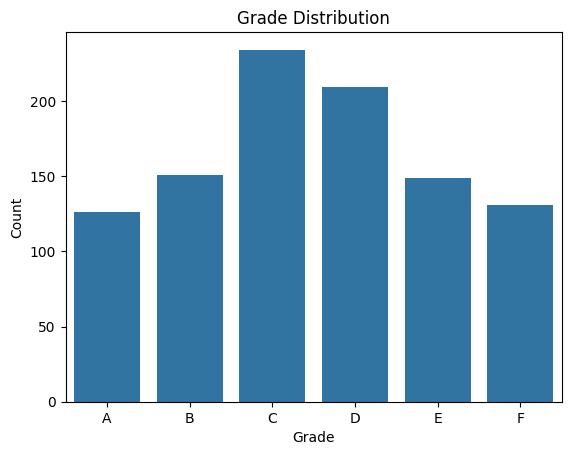

In [12]:
# Class distribution

sns.countplot(x='grade', data=habits_df, order=['A', 'B', 'C', 'D', 'E', 'F'])
plt.title('Grade Distribution')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.show()


Tuning: Logistic Regression
Best parameters:  {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}

Training: Logistic Regression
Accuracy: 0.57
Classification Report:
              precision    recall  f1-score   support

           A       0.76      0.88      0.81        25
           B       0.41      0.40      0.41        30
           C       0.50      0.57      0.53        47
           D       0.56      0.52      0.54        42
           E       0.57      0.40      0.47        30
           F       0.71      0.77      0.74        26

    accuracy                           0.57       200
   macro avg       0.59      0.59      0.59       200
weighted avg       0.57      0.57      0.57       200

Accuracy with Grid Search: 0.60
Classification Report with Grid Search:
              precision    recall  f1-score   support

           A       0.81      0.88      0.85        25
           B       0.52      0.57      0.54        30
           C       0.53 

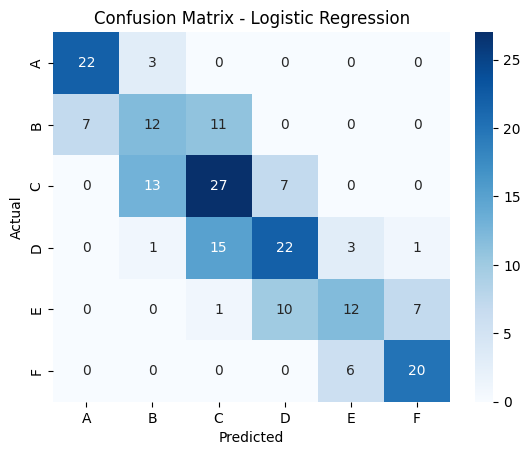

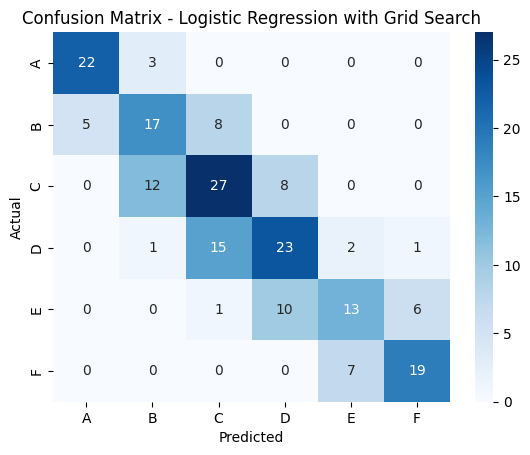


Tuning: Random Forest
Best parameters:  {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}

Training: Random Forest
Accuracy: 0.51
Classification Report:
              precision    recall  f1-score   support

           A       0.63      0.76      0.69        25
           B       0.40      0.33      0.36        30
           C       0.45      0.51      0.48        47
           D       0.46      0.50      0.48        42
           E       0.50      0.30      0.38        30
           F       0.68      0.73      0.70        26

    accuracy                           0.51       200
   macro avg       0.52      0.52      0.52       200
weighted avg       0.50      0.51      0.50       200

Accuracy with Grid Search: 0.53
Classification Report with Grid Search:
              precision    recall  f1-score   support

           A       0.62      0.72      0.67        25
           B       0.45      0.33      0.38        30
           C       0

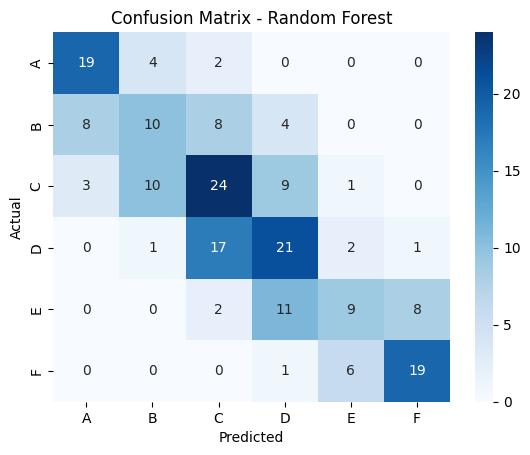

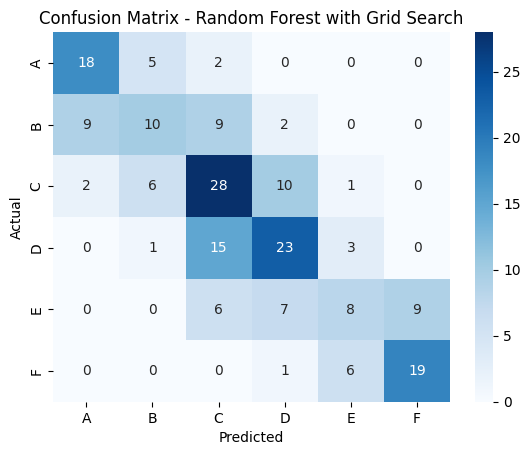


Tuning: Support Vector Machine
Best parameters:  {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}

Training: Support Vector Machine
Accuracy: 0.59
Classification Report:
              precision    recall  f1-score   support

           A       0.78      0.72      0.75        25
           B       0.48      0.53      0.51        30
           C       0.58      0.64      0.61        47
           D       0.54      0.64      0.59        42
           E       0.56      0.30      0.39        30
           F       0.73      0.73      0.73        26

    accuracy                           0.59       200
   macro avg       0.61      0.59      0.60       200
weighted avg       0.60      0.59      0.59       200

Accuracy with Grid Search: 0.59
Classification Report with Grid Search:
              precision    recall  f1-score   support

           A       0.86      0.72      0.78        25
           B       0.42      0.47      0.44        30
           C   

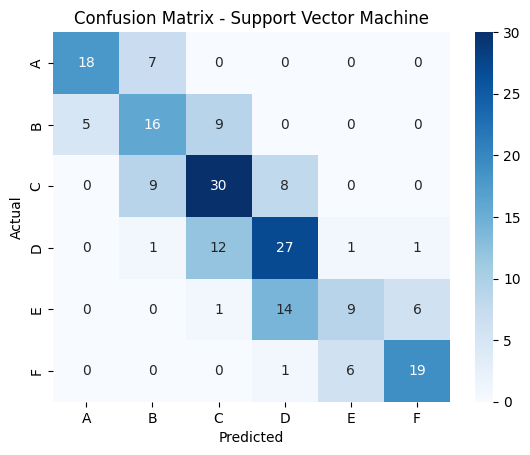

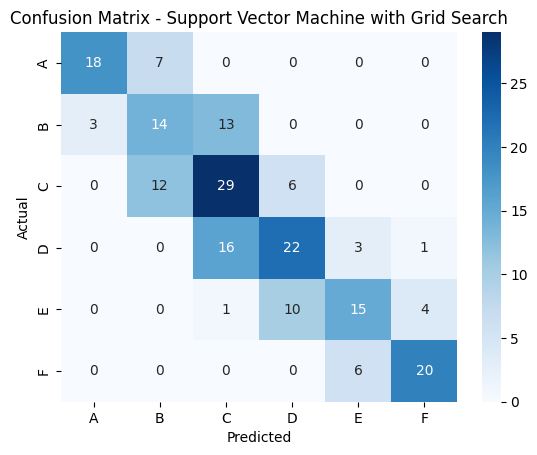


Tuning: K-Nearest Neighbors
Best parameters:  {'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}

Training: K-Nearest Neighbors
Accuracy: 0.38
Classification Report:
              precision    recall  f1-score   support

           A       0.65      0.52      0.58        25
           B       0.33      0.33      0.33        30
           C       0.30      0.45      0.36        47
           D       0.39      0.40      0.40        42
           E       0.19      0.13      0.16        30
           F       0.62      0.38      0.48        26

    accuracy                           0.38       200
   macro avg       0.41      0.37      0.38       200
weighted avg       0.39      0.38      0.38       200

Accuracy with Grid Search: 0.42
Classification Report with Grid Search:
              precision    recall  f1-score   support

           A       0.79      0.60      0.68        25
           B       0.36      0.33      0.34        30
           C       0.33      0.53      0.

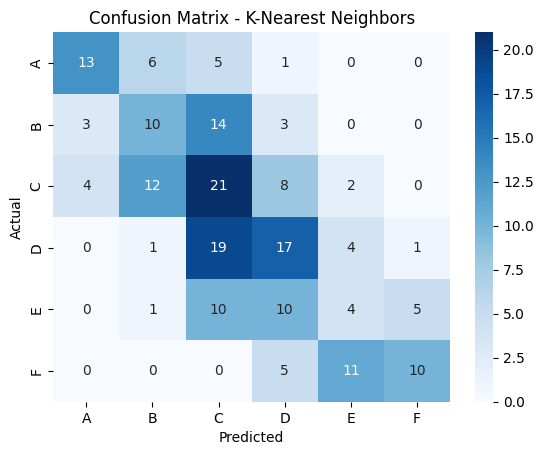

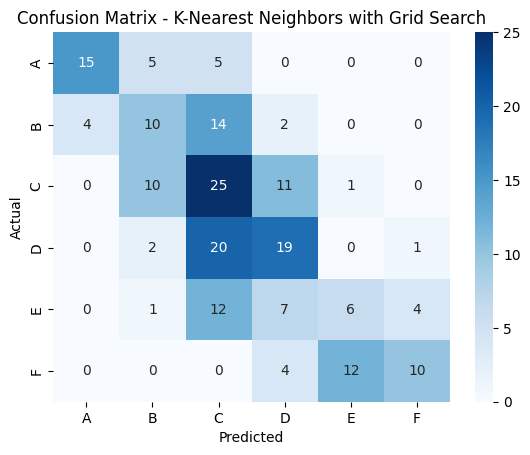

In [14]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV

X = habits_df.drop(['exam_score', 'grade'], axis=1)
y = habits_df['grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

# Define classifier models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}


param_grids = {
     "Logistic Regression": {
         'classifier__C': [0.01, 0.1, 1, 10],
         'classifier__penalty': ['l2'],
         'classifier__solver': ['lbfgs']
      },
     "Random Forest": {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [None, 10],
        'classifier__min_samples_split': [2, 5]
      },
     "Support Vector Machine": {
         'classifier__C': [0.1, 1, 10],
         'classifier__kernel': ['linear', 'rbf'],
         'classifier__gamma': ['scale', 'auto']
      },
     "K-Nearest Neighbors": {
         'classifier__n_neighbors': [3, 5, 7],
         'classifier__weights': ['uniform', 'distance']
      }
}



# Tune, train and evaluate each model
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('classifier', model)
    ])

    print(f"\nTuning: {name}")
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    print("Best parameters: ", grid_search.best_params_)
    best_model = grid_search.best_estimator_

    print(f"\nTraining: {name}")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_grid_search = best_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    acc_grid_search = accuracy_score(y_test, y_pred_grid_search)
    print(f"Accuracy: {acc:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy with Grid Search: {acc_grid_search:.2f}")
    print("Classification Report with Grid Search:")
    print(classification_report(y_test, y_pred_grid_search))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=["A", "B", "C", "D", "E", "F"])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["A", "B", "C", "D", "E", "F"],
                yticklabels=["A", "B", "C", "D", "E", "F"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    cm_grid_search = confusion_matrix(y_test, y_pred_grid_search, labels=["A", "B", "C", "D", "E", "F"])
    sns.heatmap(cm_grid_search, annot=True, fmt='d', cmap='Blues',
                xticklabels=["A", "B", "C", "D", "E", "F"],
                yticklabels=["A", "B", "C", "D", "E", "F"])
    plt.title(f"Confusion Matrix - {name} with Grid Search")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

### Regression


Tuning: Linear Regression
Best parameters:  {}

🔧 Training: Linear Regression
MAE:  4.19
MAE after Grid Search:  4.19
MSE:  26.53
MSE after Grid Search:  26.53
RMSE: 5.15
RMSE after Grid Search: 5.15
R²:   0.90
R² after Grid Search: 0.90


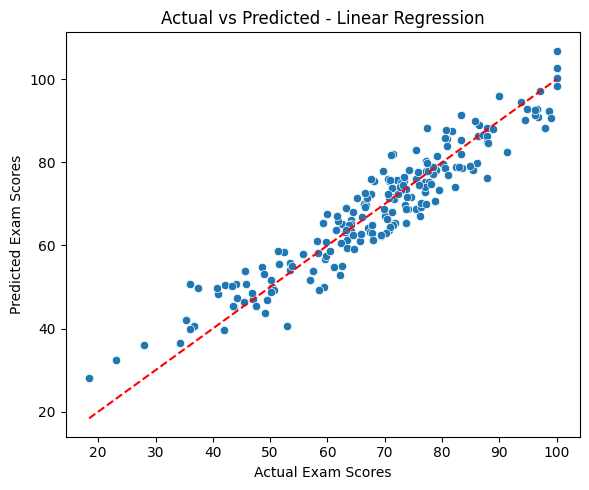

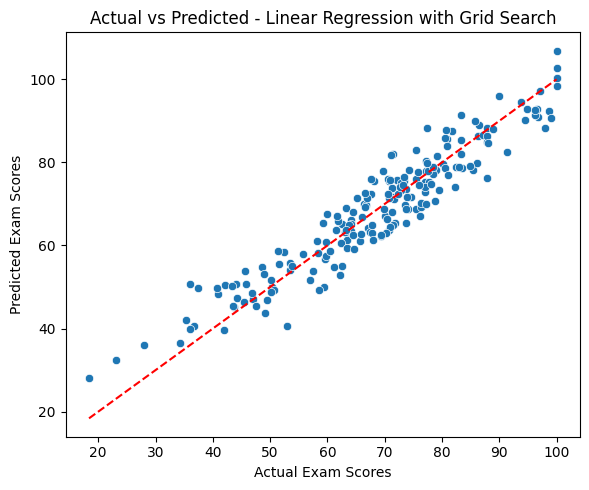


Tuning: Random Forest Regressor
Best parameters:  {'regressor__max_depth': None, 'regressor__n_estimators': 100}

🔧 Training: Random Forest Regressor
MAE:  5.00
MAE after Grid Search:  5.00
MSE:  39.99
MSE after Grid Search:  39.99
RMSE: 6.32
RMSE after Grid Search: 6.32
R²:   0.84
R² after Grid Search: 0.84


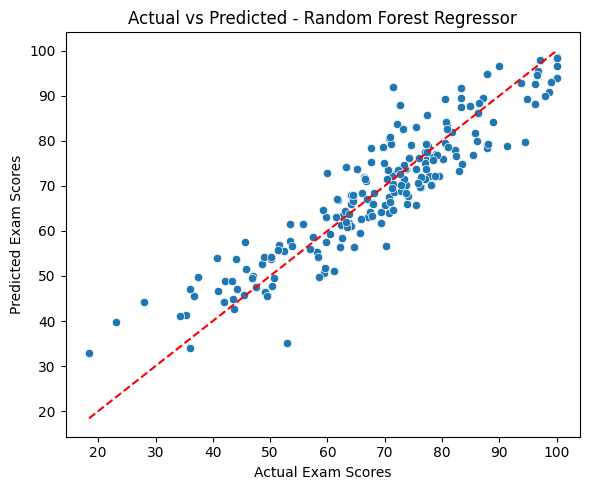

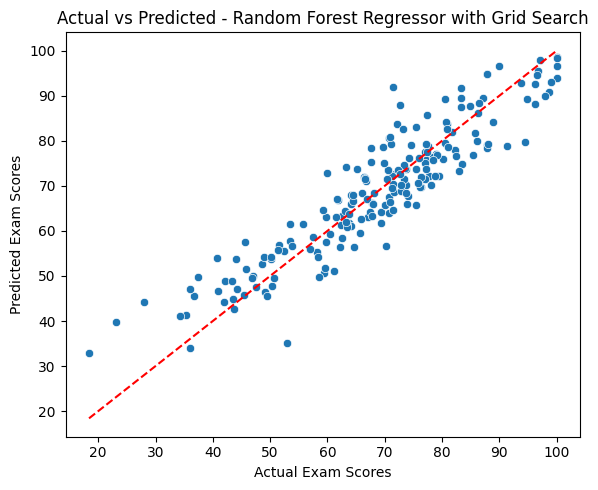


Tuning: Gradient Boosting Regressor
Best parameters:  {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 100}

🔧 Training: Gradient Boosting Regressor
MAE:  4.64
MAE after Grid Search:  4.64
MSE:  31.89
MSE after Grid Search:  31.89
RMSE: 5.65
RMSE after Grid Search: 5.65
R²:   0.88
R² after Grid Search: 0.88


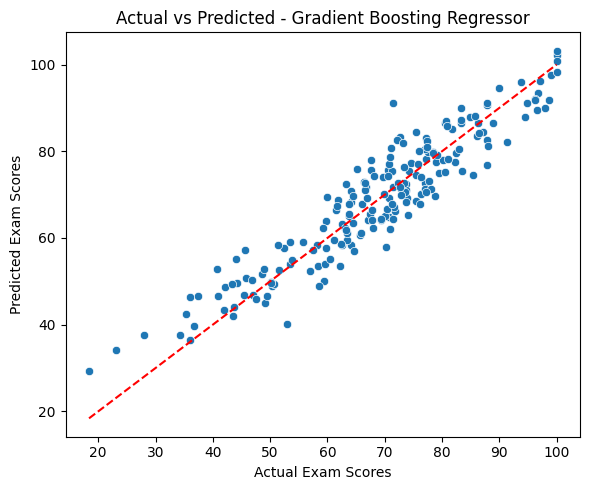

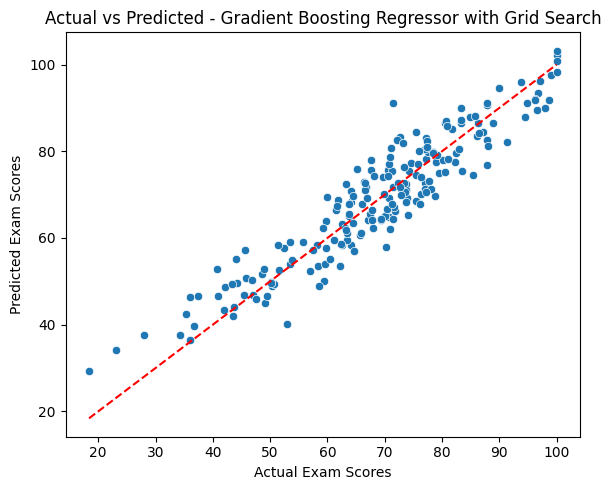

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

X = habits_df.drop(['exam_score', 'grade'], axis=1)
y = habits_df['exam_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define regression models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42)
}

# Define parameter grids for Grid Search
param_grids = {
    "Linear Regression": {},
    "Random Forest Regressor": {
        'regressor__n_estimators': [50, 100],
        'regressor__max_depth': [None, 10, 20]
    },
    "Gradient Boosting Regressor": {
        'regressor__n_estimators': [50, 100],
        'regressor__learning_rate': [0.01, 0.1, 1.0]
    }
}

# Train and evaluate each model
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('regressor', model)
    ])

    print(f"\nTuning: {name}")
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring="neg_mean_squared_error")
    grid_search.fit(X_train, y_train)
    print("Best parameters: ", grid_search.best_params_)
    best_model = grid_search.best_estimator_

    print(f"\n🔧 Training: {name}")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_grid_search = best_model.predict(X_test)

    # Evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mae_grid_search = mean_absolute_error(y_test, y_pred_grid_search)
    mse = mean_squared_error(y_test, y_pred)
    mse_grid_search = mean_squared_error(y_test, y_pred_grid_search)
    rmse = np.sqrt(mse)
    rmse_grid_search = np.sqrt(mse_grid_search)
    r2 = r2_score(y_test, y_pred)
    r2_grid_search = r2_score(y_test, y_pred_grid_search)

    print(f"MAE:  {mae:.2f}")
    print(f"MAE after Grid Search:  {mae_grid_search:.2f}")
    print(f"MSE:  {mse:.2f}")
    print(f"MSE after Grid Search:  {mse_grid_search:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"RMSE after Grid Search: {rmse_grid_search:.2f}")
    print(f"R²:   {r2:.2f}")
    print(f"R² after Grid Search: {r2_grid_search:.2f}")

    # Plot predictions vs actual values
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel("Actual Exam Scores")
    plt.ylabel("Predicted Exam Scores")
    plt.title(f"Actual vs Predicted - {name}")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y_test, y=y_pred_grid_search)
    plt.xlabel("Actual Exam Scores")
    plt.ylabel("Predicted Exam Scores")
    plt.title(f"Actual vs Predicted - {name} with Grid Search")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
    plt.tight_layout()
    plt.show()

As we can see, the enhancement of the models doesn't make a difference, as after enhancing the results by all of the evaluation metrics are the same.

### Classification and regression comparison

In [18]:
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.stats import ttest_rel, wilcoxon
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Helper to convert exam score to letter grade
def score_to_grade(score):
    if score >= 90:
        return "A"
    elif score >= 80:
        return "B"
    elif score >= 70:
        return "C"
    elif score >= 60:
        return "D"
    elif score >= 50:
        return "E"
    else:
        return "F"

# Helper for classification models
def crossval_classification_scores(model, X, y_grades, cv, preprocessor):
    pipeline = Pipeline([('preprocessing', preprocessor), ('model', model)])
    y_pred = cross_val_predict(pipeline, X, y_grades, cv=cv)
    return accuracy_score(y_grades, y_pred), y_pred

# Helper for regression models
def crossval_regression_scores(model, X, y_scores, cv, preprocessor):
    pipeline = Pipeline([('preprocessing', preprocessor), ('model', model)])
    y_pred_scores = cross_val_predict(pipeline, X, y_scores, cv=cv)
    y_pred_grades = pd.Series(y_pred_scores).apply(score_to_grade)
    y_true_grades = y_scores.apply(score_to_grade)
    return accuracy_score(y_true_grades, y_pred_grades), y_pred_grades

# Main comparison function
def compare_models(df, target_col, classifier_models, regressor_models, preprocessor, k_folds=5, random_state=42):
    X = df.drop(columns=[target_col])
    y_scores = df[target_col]
    y_grades = y_scores.apply(score_to_grade)

    cv = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)

    print("\nCLASSIFICATION MODELS:")
    clf_results = {}
    for name, model in classifier_models.items():
        acc, preds = crossval_classification_scores(model, X, y_grades, cv, preprocessor)
        clf_results[name] = preds
        print(f"\n{name}")
        print(f"Mean Accuracy: {acc:.3f}")

    print("\nREGRESSION MODELS:")
    reg_results = {}
    for name, model in regressor_models.items():
        acc, preds = crossval_regression_scores(model, X, y_scores, cv, preprocessor)
        reg_results[name] = preds
        print(f"\n{name}")
        print(f"Mean Accuracy: {acc:.3f}")

    # Combine all results
    all_results = {**clf_results, **reg_results}
    y_true = y_grades

    print("\nSTATISTICAL TESTING BETWEEN MODELS:")
    model_names = list(all_results.keys())
    for i in range(len(model_names)):
        for j in range(i + 1, len(model_names)):
            model_1 = model_names[i]
            model_2 = model_names[j]
            pred_1 = all_results[model_1]
            pred_2 = all_results[model_2]

            acc_1 = (pred_1 == y_true).astype(int)
            acc_2 = (pred_2 == y_true).astype(int)

            # Paired t-test
            t_stat, p_t = ttest_rel(acc_1, acc_2)
            # Wilcoxon test
            try:
                w_stat, p_w = wilcoxon(acc_1, acc_2)
            except ValueError:
                w_stat, p_w = None, None

            print(f"\n{model_1} vs {model_2}")
            print(f"T-test p-value:     {p_t:.4f}")
            print(f"Wilcoxon p-value:   {p_w:.4f}" if p_w is not None else "Wilcoxon test could not be run (all differences are zero)")


In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

classifier_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Support Vector Machine": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}

regressor_models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR(),
    "K-Nearest Neighbors Regressor": KNeighborsRegressor(n_neighbors=5)
}

compare_models(
    df=habits_df,
    target_col="exam_score",
    classifier_models=classifier_models,
    regressor_models=regressor_models,
    preprocessor=preprocessor
)


CLASSIFICATION MODELS:

Logistic Regression
Mean Accuracy: 0.608

Random Forest
Mean Accuracy: 0.499

Gradient Boosting
Mean Accuracy: 0.507

Naive Bayes
Mean Accuracy: 0.405

Support Vector Machine
Mean Accuracy: 0.580

K-Nearest Neighbors
Mean Accuracy: 0.378

REGRESSION MODELS:

Linear Regression
Mean Accuracy: 0.655

Ridge Regression
Mean Accuracy: 0.654

Lasso Regression
Mean Accuracy: 0.661

Random Forest Regressor
Mean Accuracy: 0.570

Gradient Boosting Regressor
Mean Accuracy: 0.616

Support Vector Regressor
Mean Accuracy: 0.512

K-Nearest Neighbors Regressor
Mean Accuracy: 0.458

STATISTICAL TESTING BETWEEN MODELS:

Logistic Regression vs Random Forest
T-test p-value:     0.0000
Wilcoxon p-value:   0.0000

Logistic Regression vs Gradient Boosting
T-test p-value:     0.0000
Wilcoxon p-value:   0.0000

Logistic Regression vs Naive Bayes
T-test p-value:     0.0000
Wilcoxon p-value:   0.0000

Logistic Regression vs Support Vector Machine
T-test p-value:     0.0466
Wilcoxon p-valu

### Clustering

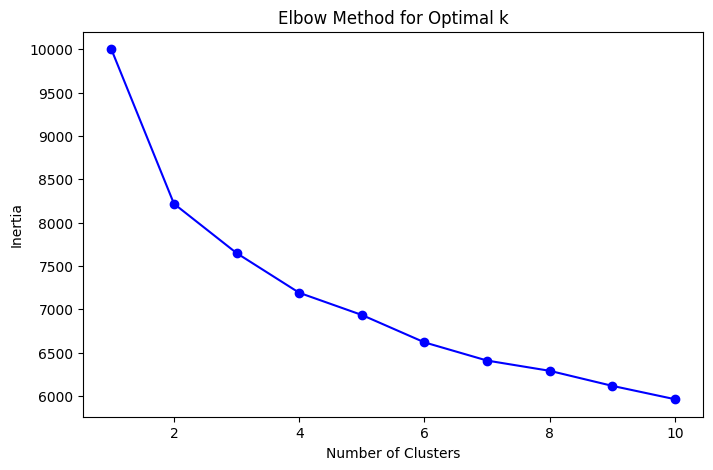

In [21]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Select only numeric features for clustering
numeric_features = habits_df.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
habits_df_scaled = scaler.fit_transform(habits_df[numeric_features])

# Elbow method to determine optimal number of clusters
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(habits_df_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

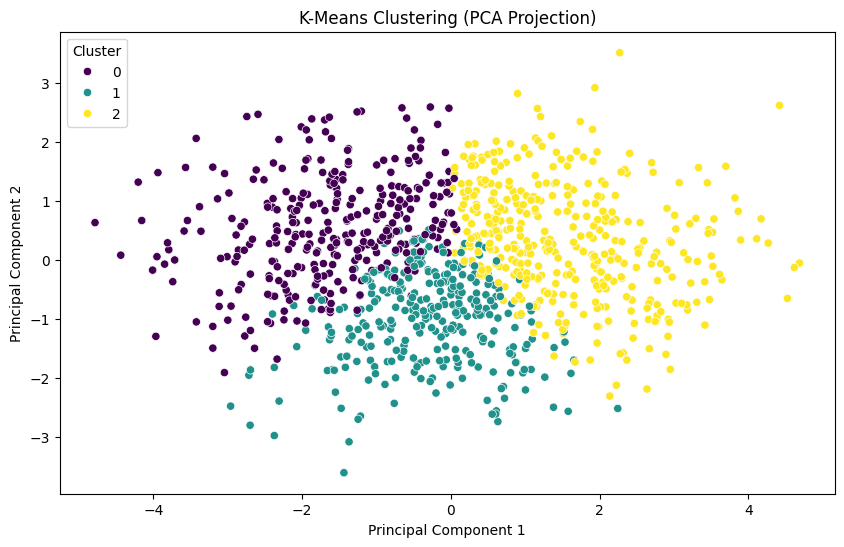

In [22]:
# We see elbow point at around 3 and decide that optimal k is 3
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
habits_df['Cluster'] = kmeans.fit_predict(habits_df_scaled)

# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(habits_df_scaled)
habits_df['PC1'] = pca_components[:, 0]
habits_df['PC2'] = pca_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=habits_df, x='PC1', y='PC2', hue='Cluster', palette='viridis')
plt.title('K-Means Clustering (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

Cluster Profiles (Mean of Key Features):
         study_hours_per_day  attendance_percentage  mental_health_rating  \
Cluster                                                                     
0                   2.190794              84.417460              4.136508   
1                   3.363455              77.538870              6.913621   
2                   4.811458              89.065104              5.348958   

         exam_score  engagement_score  
Cluster                                
0         51.031746          0.554063  
1         72.527243          0.590312  
2         82.541146          0.735172  


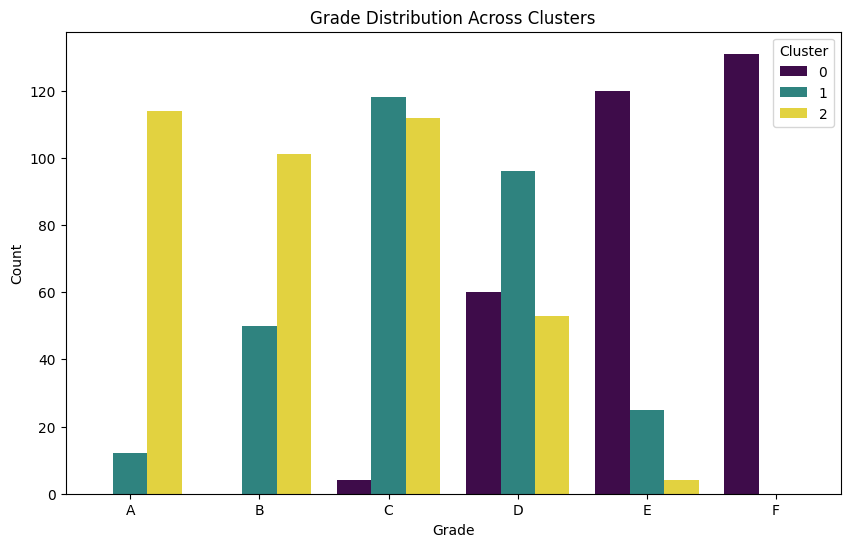


Cross-Tabulation of Grades and Clusters:
Cluster    0    1    2
grade                 
A          0   12  114
B          0   50  101
C          4  118  112
D         60   96   53
E        120   25    4
F        131    0    0


In [23]:
# Profile each cluster
cluster_profiles = habits_df.groupby('Cluster')[[
    'study_hours_per_day',
    'attendance_percentage',
    'mental_health_rating',
    'exam_score',
    'engagement_score'
]].mean()
print("Cluster Profiles (Mean of Key Features):")
print(cluster_profiles)

# Compare the distribution of grades across clusters using a count plot
plt.figure(figsize=(10, 6))
sns.countplot(data=habits_df, x='grade', hue='Cluster', palette='viridis', order=['A', 'B', 'C', 'D', 'E', 'F'])
plt.title('Grade Distribution Across Clusters')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()

# Cross-tabulation of grades and clusters
grade_cluster_crosstab = pd.crosstab(habits_df['grade'], habits_df['Cluster'])
print("\nCross-Tabulation of Grades and Clusters:")
print(grade_cluster_crosstab)
